In [397]:
# import modules
import os
import pandas as pd  # For loading and working with tables (dataframes)
import geopandas as gpd
import matplotlib.pyplot as plt # For plotting
import matplotlib.dates as mdates  # For formatting time axes in plots
import datetime

import os
import time
import json
import requests
import numpy as np
import pandas as pd

from shapely import geometry as sgeom
from requests.auth import HTTPBasicAuth

# Import NOAA GML custom modules
# Included in ./py directory


In [398]:
deforestation_data_source = 'https://worldrainforests.com/amazon/deforestation-rate.html'

In [399]:
with open('./envar.txt') as file :
    API_KEY = file.readline()
# URL to access the Orders API
URL = 'https://api.planet.com/compute/ops/orders/v2'

# construct auth tuple for use in the requests library
BASIC_AUTH = (API_KEY, '')
auth = HTTPBasicAuth(API_KEY, '')
response = requests.get(URL, auth=auth)
response

<Response [401]>

In [400]:
# Setup the stats URL
stats_url = "{}/stats".format(URL)
searches_url = "{}/searches".format(URL)
print(stats_url)
print(searches_url)

https://api.planet.com/compute/ops/orders/v2/stats
https://api.planet.com/compute/ops/orders/v2/searches


In [401]:
# Helper function to printformatted JSON using the json module
def p(data):
    print(json.dumps(data, indent=2))
    
def get_meta(page_info):
    """Transforms request .json response into pd.DataFrame() and get the images metadata information.
    """
    frame = pd.DataFrame([{**{'image_id': img['id']}, **img['properties']} for img in page_info['features']])
    return frame


def shapely_geom(geom):
    """Converts the AOI geometry to a shapely structure.
    """
    aoi = {u'geometry': {u'type': u'Polygon', u'coordinates': geom['coordinates']}}
    aoi_shape = sgeom.shape(aoi['geometry'])
    return aoi_shape


def fetch_page(url, _list):
    """Paginates over API request if more than 250 results are found on Planet Catalog.
    """
    s = requests.get(url, auth=auth)
    res_code = s.status_code

    while res_code == 429:
        print('rate of requests too high! sleep 2s...')
        time.sleep(2)
        s = requests.get(url, auth=auth)
        res_code = s.status_code

    resulty = s.json()
    metadata = get_meta(resulty)
    metadata['geom'] = [shapely_geom(geom['geometry']) for geom in resulty['features']]
    _list.append(metadata)

    next_url = resulty["_links"].get("_next")

    print(next_url)

    return next_url

In [402]:
os.getcwd()

'c:\\Users\\Griffin Parker\\Documents\\Classwork\\GIS495\\Final Project\\GIS495-final-project-2025'

In [403]:
# Set default plot styles for consistent formatting
plt.rcParams['font.size'] = 16           # Base font size for text
plt.rcParams['axes.titlesize'] = 18      # Title font size for each plot
plt.rcParams['axes.labelsize'] = 16      # Font size for axis labels
plt.rcParams['xtick.labelsize'] = 14     # Font size for tick labels on x-axis
plt.rcParams['ytick.labelsize'] = 14     # Font size for tick labels on y-axis
plt.rcParams['legend.fontsize'] = 14     # Font size for plot legends

In [404]:
raw_data_paths = [
    "./rawdata/co2_nat_surface-flask_1_ccgg_month.txt",
    "./rawdata/co2_abp_surface-flask_1_ccgg_month.txt"
]
n = []
for file_path in raw_data_paths :
    # First, find out how many header lines there are (they start with "#")
    with open(file_path, "r") as file:
        line = file.readline()
        if line.startswith('# number_of_header_lines: ') :
            header_lines = int(line.strip('# number_of_header_lines: '))
        # Count the number of header lines so we can skip them when reading the data
    n.append(header_lines)
    # Print the number of lines to skip
    print(f"Number of header lines in file {file_path}: {header_lines}")


Number of header lines in file ./rawdata/co2_nat_surface-flask_1_ccgg_month.txt: 55
Number of header lines in file ./rawdata/co2_abp_surface-flask_1_ccgg_month.txt: 55


In [405]:
# Now read the data, skipping the header lines
data = []
for i in range(len(raw_data_paths)) :
    file_path = raw_data_paths[i]
    print(f"path: {file_path}:")
    data.append(
        pd.read_csv(
            file_path,
            sep=r'\s+',       # Use whitespace as the separator
            skiprows=n[i],      # Skip the metadata lines
            names = ['site', 'year',  'month',  'value']         # First remaining line is the column header
        )
    )
    # Display the first 5 rows of the data
    print(data[i].head())

path: ./rawdata/co2_nat_surface-flask_1_ccgg_month.txt:
  site  year  month   value
0  NAT  2010      9  389.15
1  NAT  2010     10  389.77
2  NAT  2010     11  389.98
3  NAT  2010     12  389.80
4  NAT  2011      1  389.35
path: ./rawdata/co2_abp_surface-flask_1_ccgg_month.txt:
  site  year  month   value
0  ABP  2006     10  380.91
1  ABP  2006     11  381.02
2  ABP  2006     12  381.12
3  ABP  2007      1  381.23
4  ABP  2007      2  381.29


In [406]:
# Print the metadata/header rows at the top of the file
for file_path in raw_data_paths :
    with open(file_path, "r") as file:
        header_lines = [line.strip() for line in file if line.startswith('#')]

    print("File Header / Metadata:\n")
    for line in header_lines:
        print(line)

File Header / Metadata:

# number_of_header_lines: 55
# comment:
# comment:  ************ USE OF GML DATA ****************
# comment:
# comment: These data are made freely available to the public and the scientific
# comment: community in the belief that their wide dissemination will lead to
# comment: greater understanding and new scientific insights. To ensure that GML
# comment: receives fair credit for their work please include relevant citation
# comment: text in publications. We encourage users to contact the data providers,
# comment: who can provide detailed information about the measurements and
# comment: scientific insight.  In cases where the data are central to a
# comment: publication, coauthorship for data providers may be appropriate.
# comment:
# comment:
# comment: Please see accompanying README file, if available, for citation text.
# comment:
# comment: Every effort is made to produce the most accurate and precise
# comment: measurements possible.  However, we reser

In [407]:
data[0].columns

Index(['site', 'year', 'month', 'value'], dtype='object')

In [408]:
data[1].columns

Index(['site', 'year', 'month', 'value'], dtype='object')

In [409]:
data[0].shape

(108, 4)

In [410]:
data[1].shape

(34, 4)

In [411]:
data[0].dtypes

site      object
year       int64
month      int64
value    float64
dtype: object

In [412]:
data[1].dtypes

site      object
year       int64
month      int64
value    float64
dtype: object

In [413]:
for datum in data :
    # Convert the 'datetime' column to actual datetime objects, if it's not already
    dates = []
    for i in range(len(datum['site'])) :
        year = datum['year'][i]
        month = datum['month'][i]
        dates.append(datetime.datetime(year, month, 1))
    datum['datetime'] = dates

    # Check data types again to confirm the change
    print(datum.dtypes)

site                object
year                 int64
month                int64
value              float64
datetime    datetime64[ns]
dtype: object
site                object
year                 int64
month                int64
value              float64
datetime    datetime64[ns]
dtype: object


In [414]:
data[0].head()

,site,year,month,value,datetime
0,NAT,2010,9,389.15,2010-09-01
1,NAT,2010,10,389.77,2010-10-01
2,NAT,2010,11,389.98,2010-11-01
3,NAT,2010,12,389.80,2010-12-01
4,NAT,2011,1,389.35,2011-01-01


In [415]:
data[1].head()

,site,year,month,value,datetime
0,ABP,2006,10,380.91,2006-10-01
1,ABP,2006,11,381.02,2006-11-01
2,ABP,2006,12,381.12,2006-12-01
3,ABP,2007,1,381.23,2007-01-01
4,ABP,2007,2,381.29,2007-02-01


In [416]:
site_loc = ('Farol De Mae Luiza Lighthouse, Brazil', 'Arembepe, Bahia, Brazil')

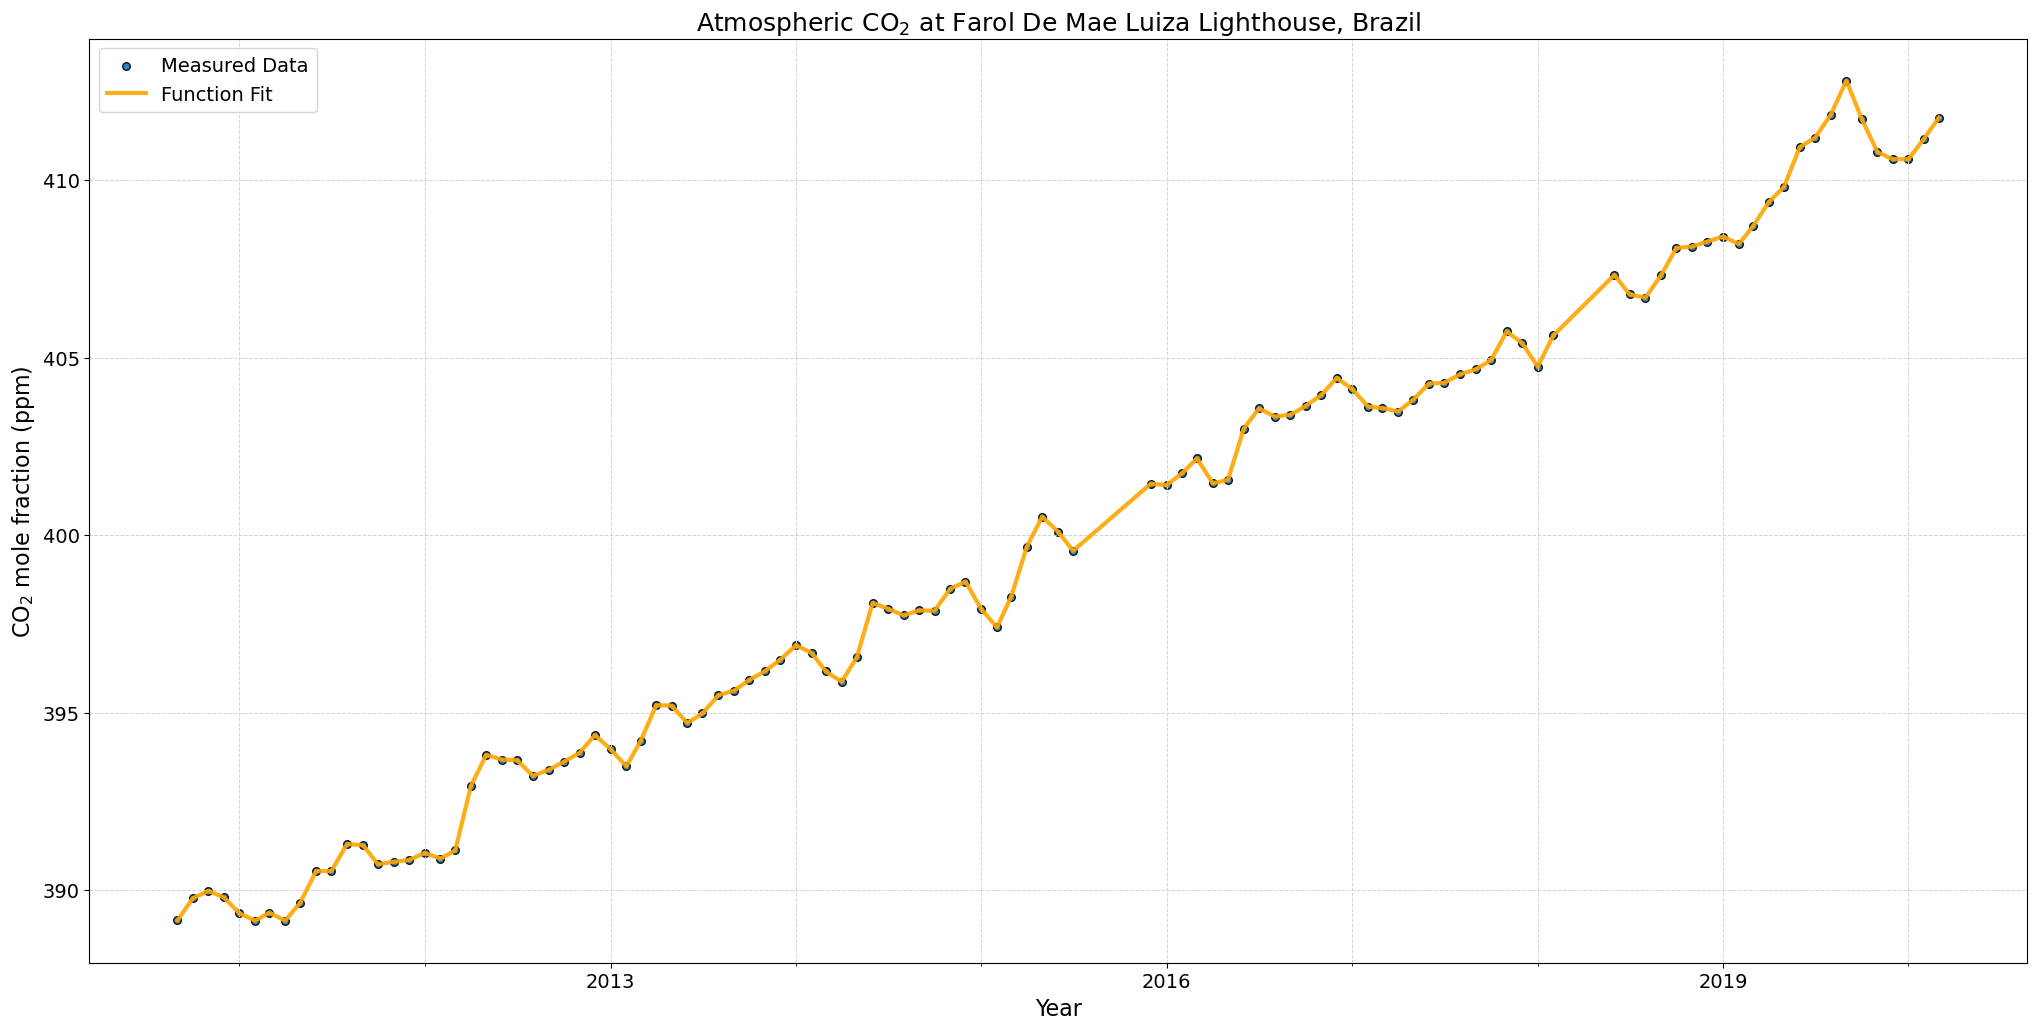

In [417]:
i = 0
plt.figure(figsize=(25, 12))
plt.scatter(data[i]['datetime'], data[i]['value'], s=30, alpha=0.9,
            edgecolors='black', label="Measured Data")
plt.plot(data[i]['datetime'], data[i]['value'], color='orange', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title(f"Atmospheric CO$_2$ at {site_loc[i]}")
plt.xlabel('Year')
plt.ylabel('CO$_2$ mole fraction (ppm)')
plt.legend()
plt.show()

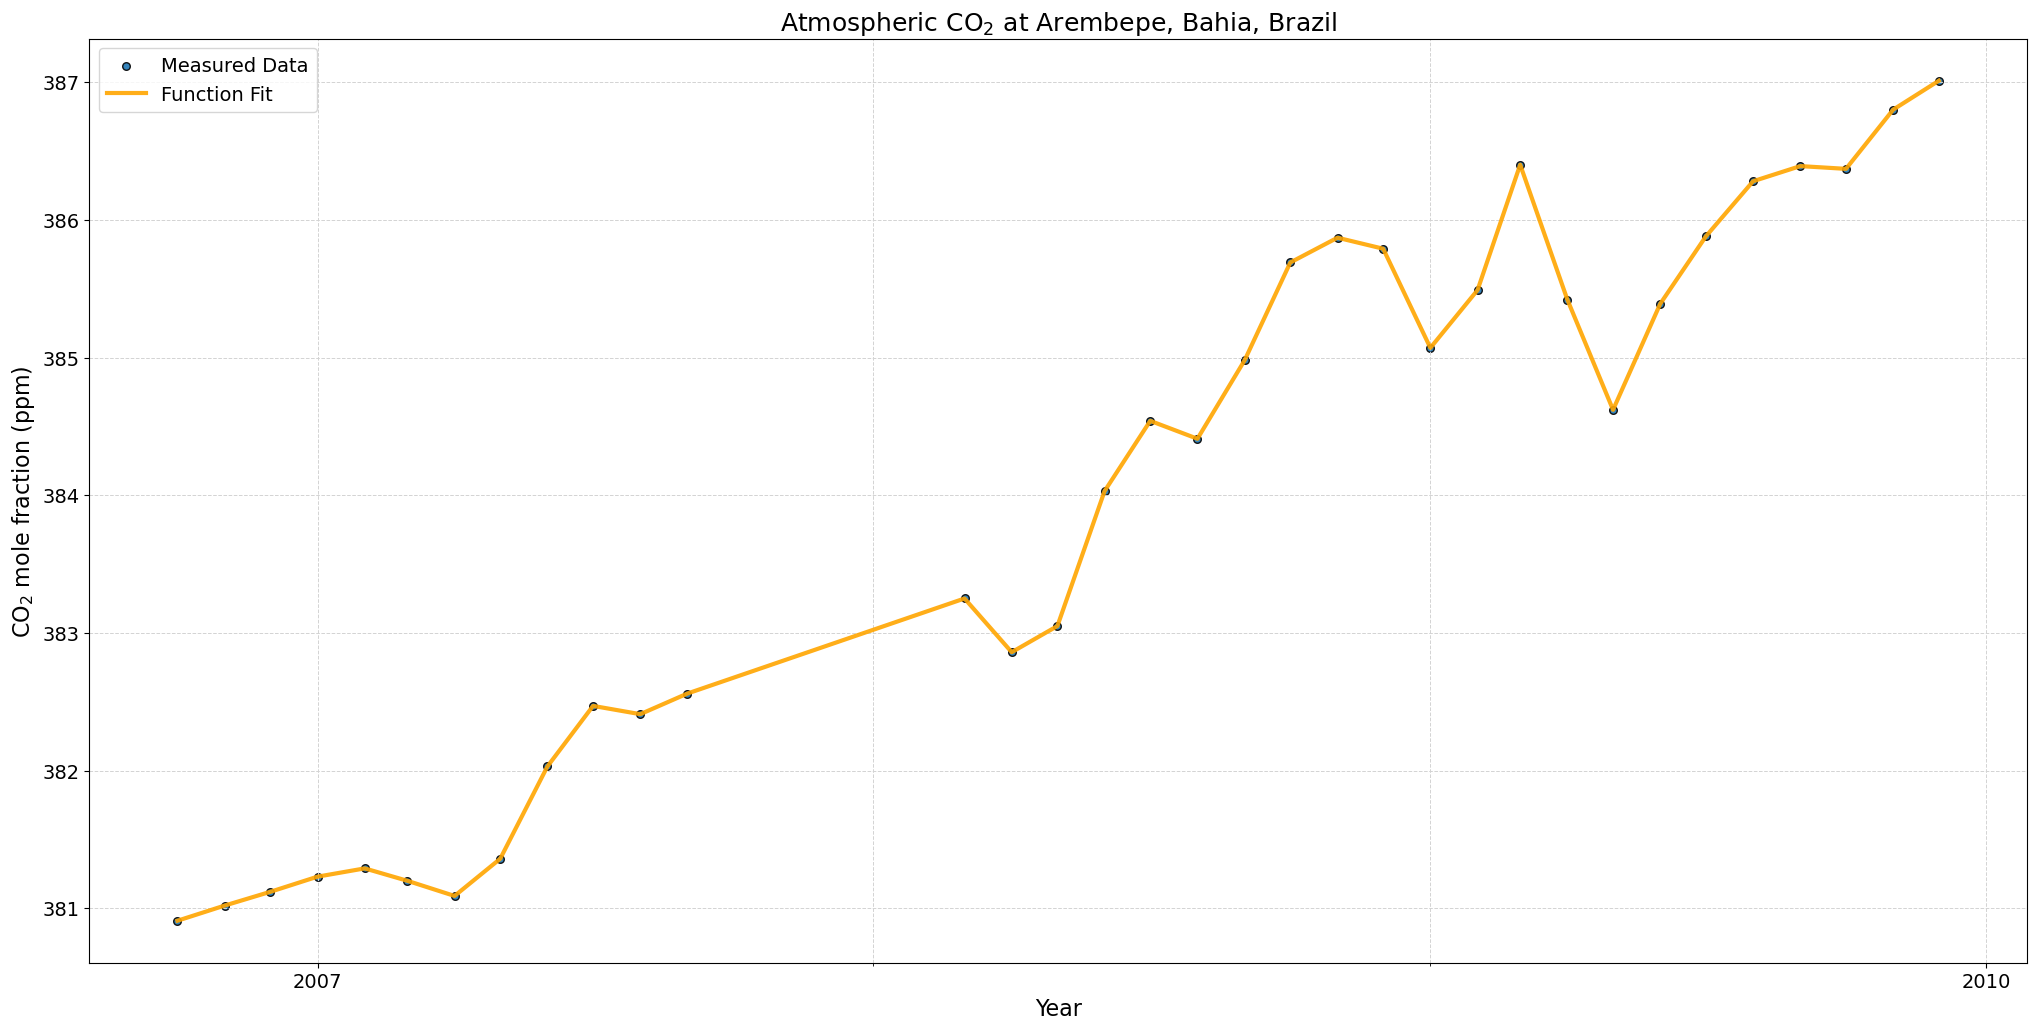

In [418]:
i = 1
plt.figure(figsize=(25, 12))
plt.scatter(data[i]['datetime'], data[i]['value'], s=30, alpha=0.9,
            edgecolors='black', label="Measured Data")
plt.plot(data[i]['datetime'], data[i]['value'], color='orange', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title(f"Atmospheric CO$_2$ at {site_loc[i]}")
plt.xlabel('Year')
plt.ylabel('CO$_2$ mole fraction (ppm)')
plt.legend()
plt.show()

In [419]:
edgecolors = ('black', 'blue')
colors = ('orange', 'green')

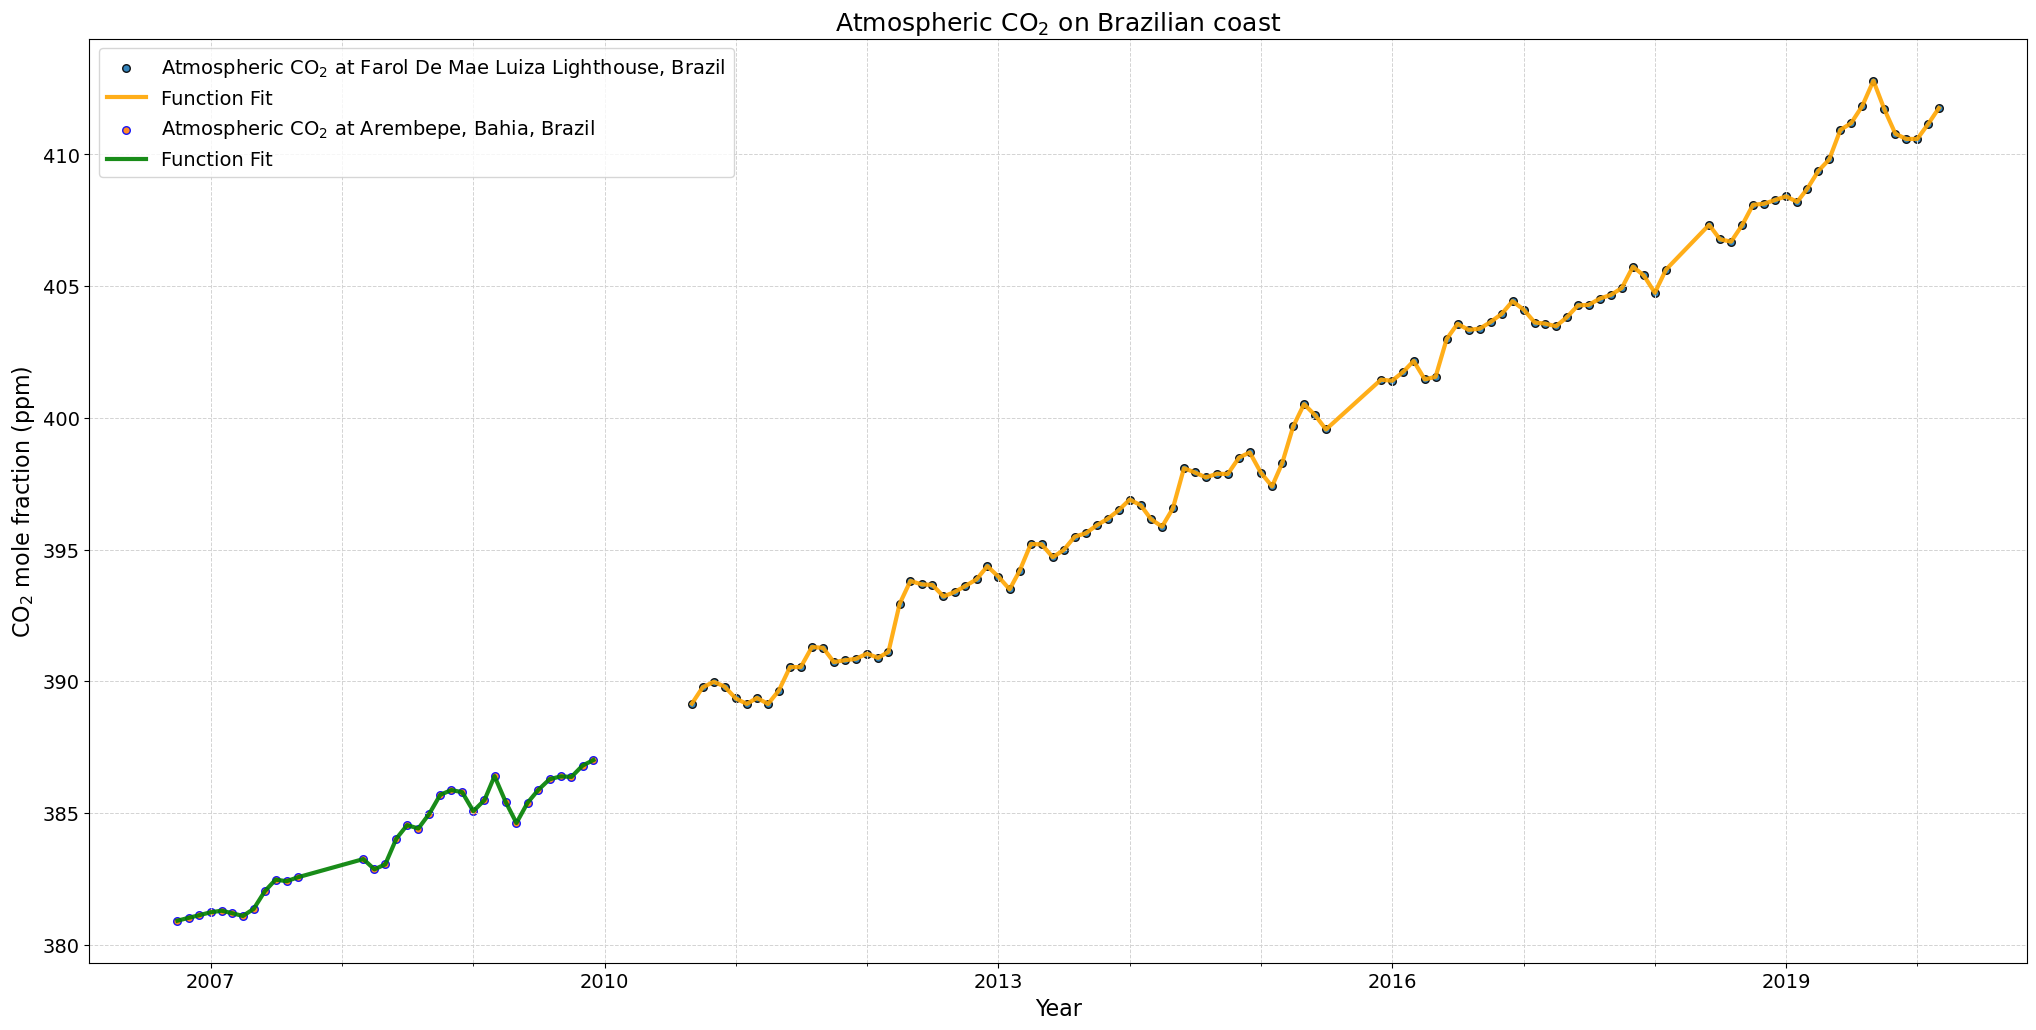

In [420]:
plt.figure(figsize=(25, 12))
for i in range(len(data)) :
    plt.scatter(data[i]['datetime'], data[i]['value'], s=30, alpha=0.9,
            edgecolors=edgecolors[i], label=f"Atmospheric CO$_2$ at {site_loc[i]}")
    plt.plot(data[i]['datetime'], data[i]['value'], color=colors[i], linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title(f"Atmospheric CO$_2$ on Brazilian coast")
plt.xlabel('Year')
plt.ylabel('CO$_2$ mole fraction (ppm)')
plt.legend()
plt.show()

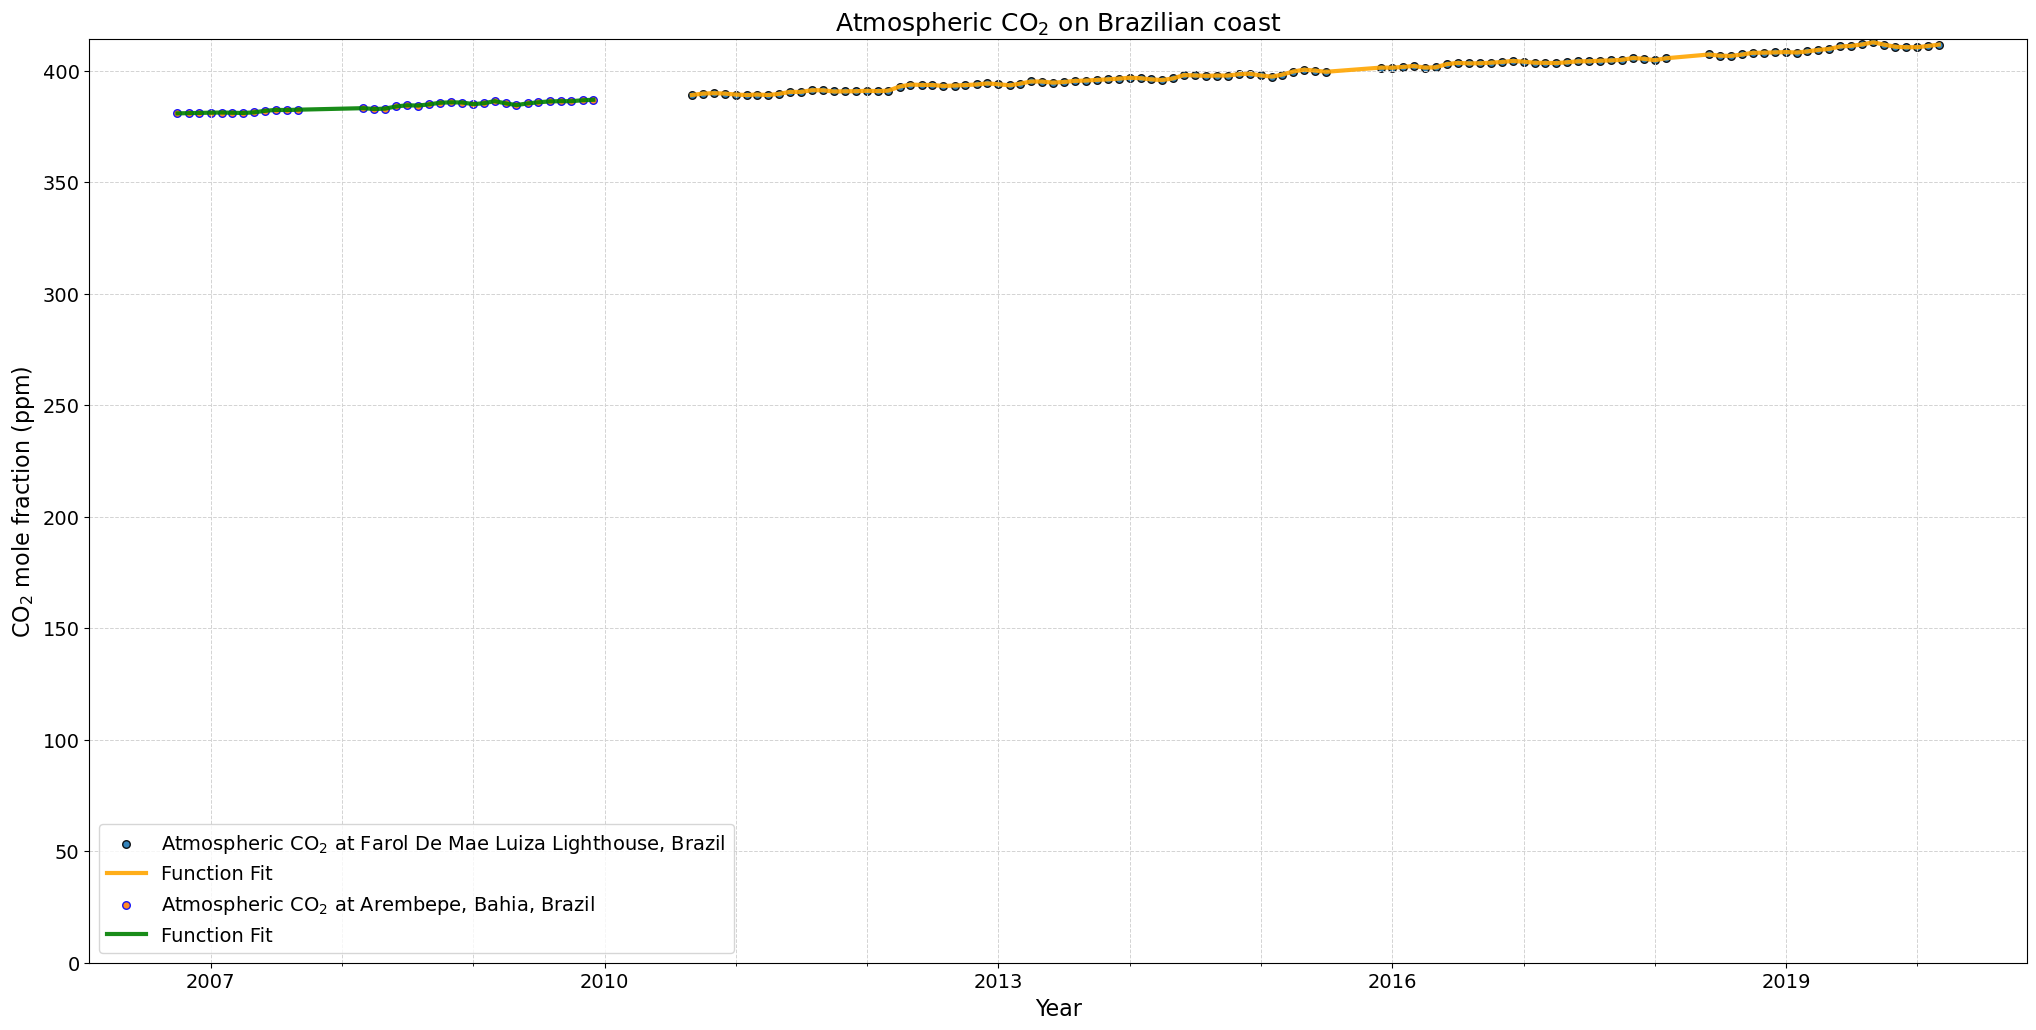

In [421]:
plt.figure(figsize=(25, 12))
for i in range(len(data)) :
    plt.scatter(data[i]['datetime'], data[i]['value'], s=30, alpha=0.9,
            edgecolors=edgecolors[i], label=f"Atmospheric CO$_2$ at {site_loc[i]}")
    plt.plot(data[i]['datetime'], data[i]['value'], color=colors[i], linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.ylim(bottom = 0)

plt.title(f"Atmospheric CO$_2$ on Brazilian coast")
plt.xlabel('Year')
plt.ylabel('CO$_2$ mole fraction (ppm)')
plt.legend()
plt.show()

In [422]:
file_rewrite = gpd.read_file('./geojson/amazonia_and_data_sites.geojson')
file_rewrite.to_file('./data/amazonia_rewrite/amazonia_and_data_sites.shp')

c:\ProgramData\miniconda3\envs\GIS495\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 6725344251419.7002 of field AREAPROJ of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(


In [423]:
deforestation_data_path = './data/deforestation_data.csv'
deforestation_data = pd.read_csv(deforestation_data_path)
deforestation_data.head()

,Month,DETER,DETER-TTM,SAD,SAD-TTM
0,Apr 2008,1124.0,156,NaN,NaN
1,May 2008,1096.0,9190,294.0,5603.0
2,Jun 2008,871.0,9064,612.0,5716.0
3,Jul 2008,324.0,8536,276.0,5031.0
4,Aug 2008,757.0,7835,102.0,4470.0


In [424]:
deforestation_data['YEAR'] = None
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
deforestation_data.head()

,Month,DETER,DETER-TTM,SAD,SAD-TTM,YEAR
0,Apr 2008,1124.0,156,NaN,NaN,None
1,May 2008,1096.0,9190,294.0,5603.0,None
2,Jun 2008,871.0,9064,612.0,5716.0,None
3,Jul 2008,324.0,8536,276.0,5031.0,None
4,Aug 2008,757.0,7835,102.0,4470.0,None


In [425]:
dates = []
deter_total = []
sad_total = []
for index, row in deforestation_data.iterrows() :
    val = row['Month']
    
    if isinstance(val, int) :
        month = val
        year = row['YEAR']
    else :
        month = months.index(val[0:3]) + 1
        year = int(val[4:8])
    if index == 0 :
        deter_tot = int(0)
        sad_tot = int(0)
    else :
        deter_tot = deter_total[index - 1]
        sad_tot = sad_total[index - 1]
    deter_tot += int(np.nan_to_num(row['DETER']))
    sad_tot += int(np.nan_to_num(row['SAD']))
    deter_total.append(deter_tot)
    sad_total.append(sad_tot)
    dates.append(datetime.datetime(year, month, 1))
    deforestation_data.loc[index, 'Month'] = month
    deforestation_data.loc[index, 'YEAR'] = year
deforestation_data['DATETIME'] = dates
deforestation_data['DETER-TOTAL'] = deter_total
deforestation_data['SAD-TOTAL'] = sad_total
deforestation_data.head()

,Month,DETER,DETER-TTM,SAD,SAD-TTM,YEAR,DATETIME,DETER-TOTAL,SAD-TOTAL
0,4,1124.0,156,NaN,NaN,2008,2008-04-01,1124,0
1,5,1096.0,9190,294.0,5603.0,2008,2008-05-01,2220,294
2,6,871.0,9064,612.0,5716.0,2008,2008-06-01,3091,906
3,7,324.0,8536,276.0,5031.0,2008,2008-07-01,3415,1182
4,8,757.0,7835,102.0,4470.0,2008,2008-08-01,4172,1284


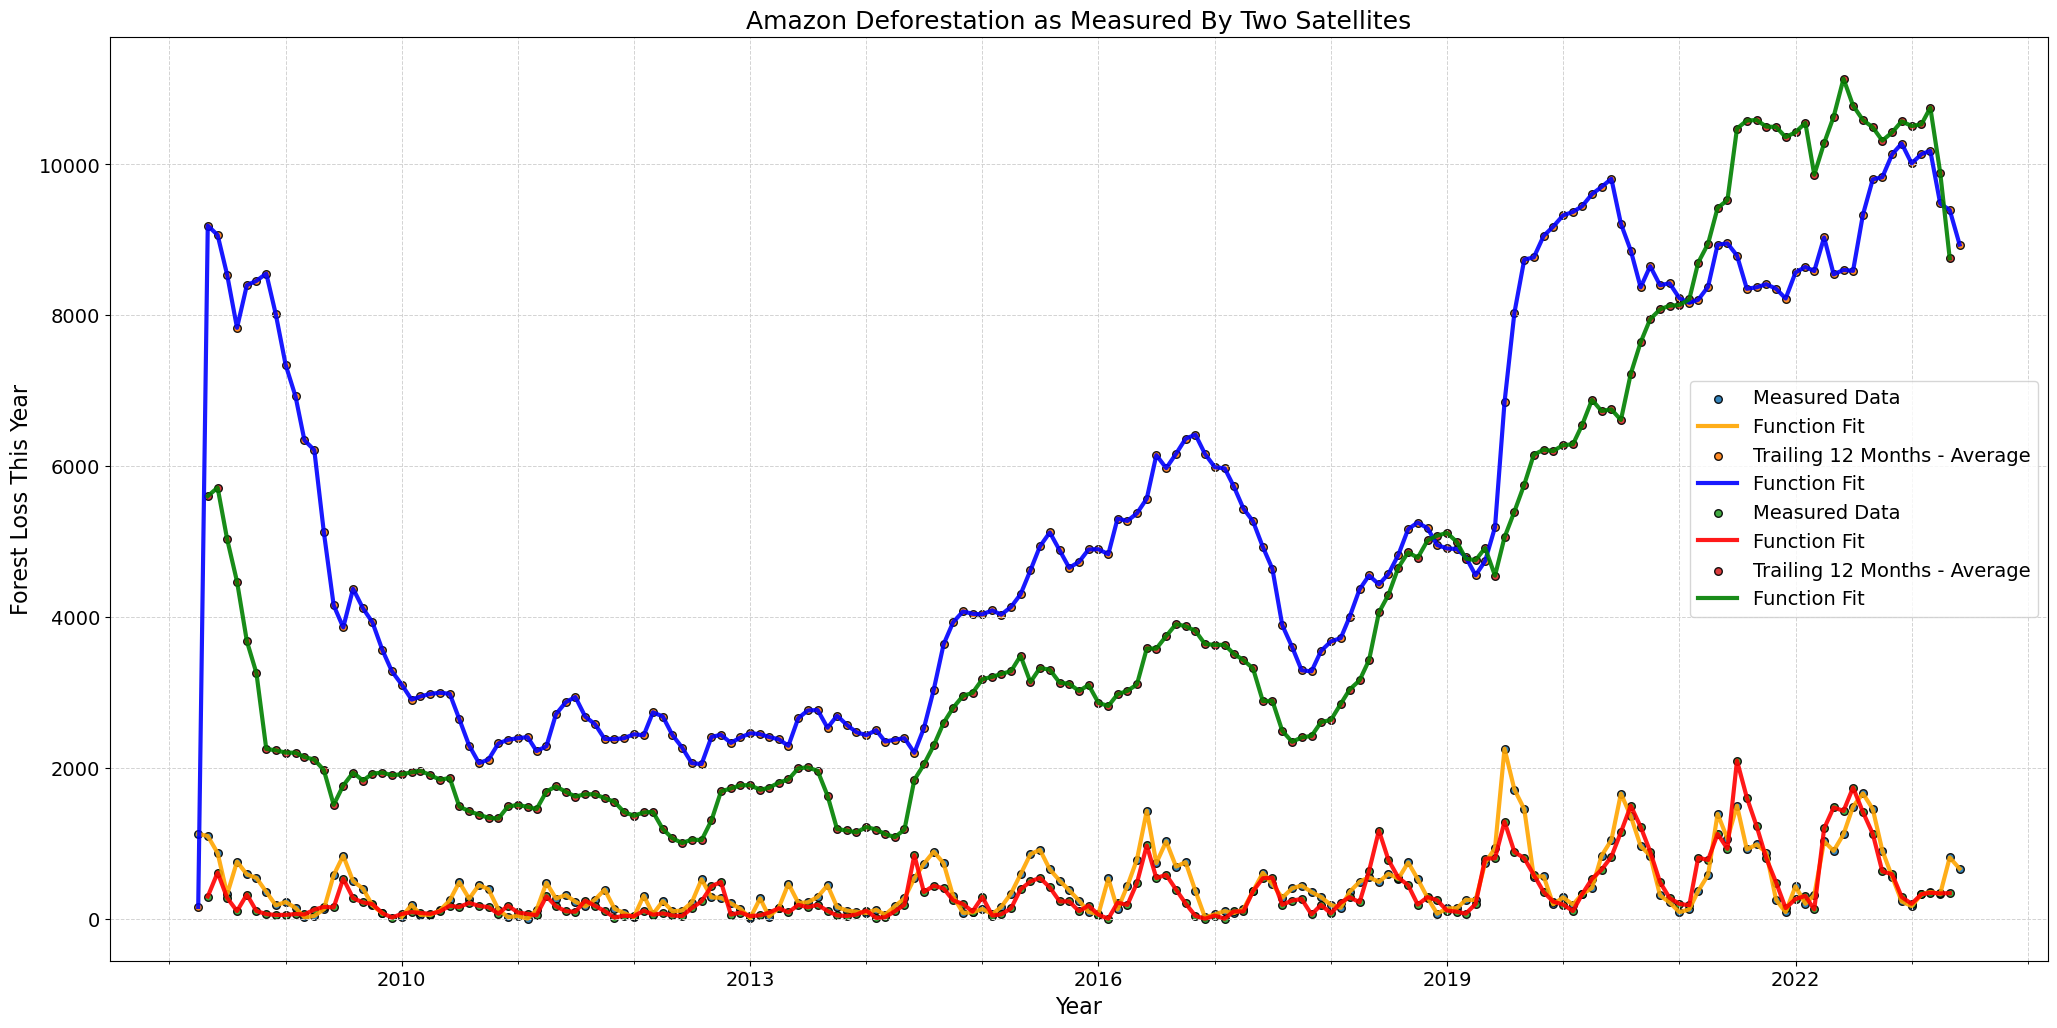

In [426]:
plt.figure(figsize=(25, 12))
plt.scatter(deforestation_data['DATETIME'], deforestation_data['DETER'], s=30, alpha=0.9,
            edgecolors='black', label="Measured Data")
plt.plot(deforestation_data['DATETIME'], deforestation_data['DETER'], color='orange', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.scatter(deforestation_data['DATETIME'], deforestation_data['DETER-TTM'], s=30, alpha=0.9,
            edgecolors='black', label="Trailing 12 Months - Average")
plt.plot(deforestation_data['DATETIME'], deforestation_data['DETER-TTM'], color='blue', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.scatter(deforestation_data['DATETIME'], deforestation_data['SAD'], s=30, alpha=0.9,
            edgecolors='black', label="Measured Data")
plt.plot(deforestation_data['DATETIME'], deforestation_data['SAD'], color='red', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.scatter(deforestation_data['DATETIME'], deforestation_data['SAD-TTM'], s=30, alpha=0.9,
            edgecolors='black', label="Trailing 12 Months - Average")
plt.plot(deforestation_data['DATETIME'], deforestation_data['SAD-TTM'], color='green', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title("Amazon Deforestation as Measured By Two Satellites")
plt.xlabel('Year')
plt.ylabel('Forest Loss This Year')
plt.legend()
plt.show()

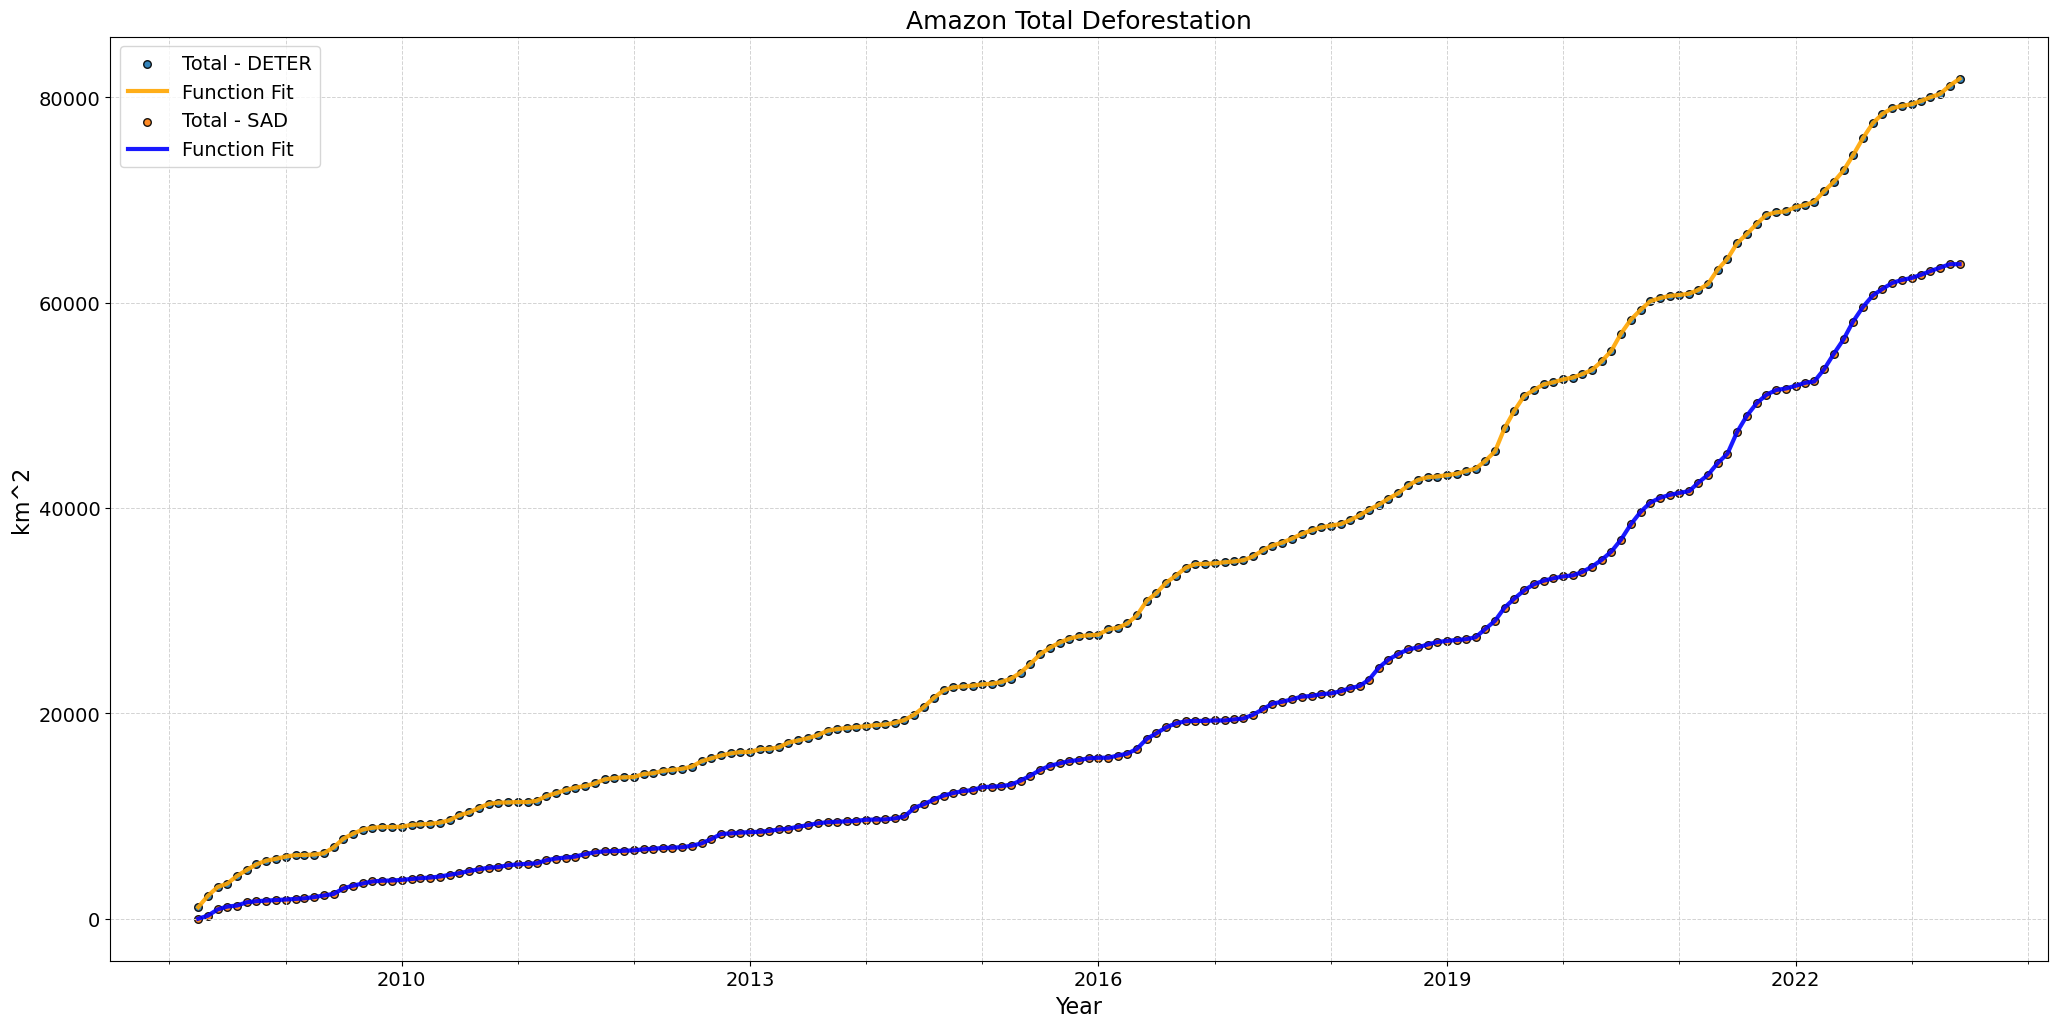

In [427]:
plt.figure(figsize=(25, 12))
plt.scatter(deforestation_data['DATETIME'], deforestation_data['DETER-TOTAL'], s=30, alpha=0.9,
            edgecolors='black', label="Total - DETER")
plt.plot(deforestation_data['DATETIME'], deforestation_data['DETER-TOTAL'], color='orange', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.scatter(deforestation_data['DATETIME'], deforestation_data['SAD-TOTAL'], s=30, alpha=0.9,
            edgecolors='black', label="Total - SAD")
plt.plot(deforestation_data['DATETIME'], deforestation_data['SAD-TOTAL'], color='blue', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
plt.gca().xaxis.set_major_locator(
    mdates.YearLocator(3))  # Major ticks every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title("Amazon Total Deforestation")
plt.xlabel('Year')
plt.ylabel('km^2')
plt.legend()
plt.show()

In [428]:
deforestation_vs_co2 = pd.DataFrame(columns = ('Datetime', 'Deforestation - DETER', 'Deforestation - SAD', 'CO2'))

In [429]:
date_lineup_co2 = data[0]['datetime'].to_list()
for date in data[1]['datetime'].to_list() :
    date_lineup_co2.append(date)
date_lineup_deforestation = deforestation_data['DATETIME'].to_list()

In [430]:
for i in range(30) :
    for date in date_lineup_co2 :
        if date not in date_lineup_deforestation :
            date_lineup_co2.remove(date)
    for date in date_lineup_deforestation :
        if date not in date_lineup_co2 :
            date_lineup_deforestation.remove(date)
    date_lineup_co2.sort()
    date_lineup_deforestation.sort()
    if date_lineup_co2 == date_lineup_deforestation :
        break
if i < 30 :
    print('SUCCESS!')
else :
    print('Failure.')

SUCCESS!


In [431]:
defo_deter = []
defo_sad = []
co2 = []
for i in range(2) :
    data[i].sort_values(by = 'datetime')
for i, row in data[1].iterrows() :
    if row['datetime'] in date_lineup_co2 :
        co2.append(row['value'])
for i, row in data[0].iterrows() :
    if row['datetime'] in date_lineup_co2 :
        co2.append(row['value'])
deforestation_data.sort_values(by = 'DATETIME')
for i, row in deforestation_data.iterrows() :
    if row['DATETIME'] in date_lineup_deforestation :
        defo_deter.append(row['DETER-TOTAL'])
        defo_sad.append(row['SAD-TOTAL'])

deforestation_vs_co2['CO2'] = co2
deforestation_vs_co2['Deforestation - DETER'] = defo_deter
deforestation_vs_co2['Deforestation - SAD'] = defo_sad
deforestation_vs_co2['Datetime'] = date_lineup_co2
deforestation_vs_co2.head()

,Datetime,Deforestation - DETER,Deforestation - SAD,CO2
0,2008-04-01,1124,0,382.86
1,2008-05-01,2220,294,383.05
2,2008-06-01,3091,906,384.03
3,2008-07-01,3415,1182,384.54
4,2008-08-01,4172,1284,384.41


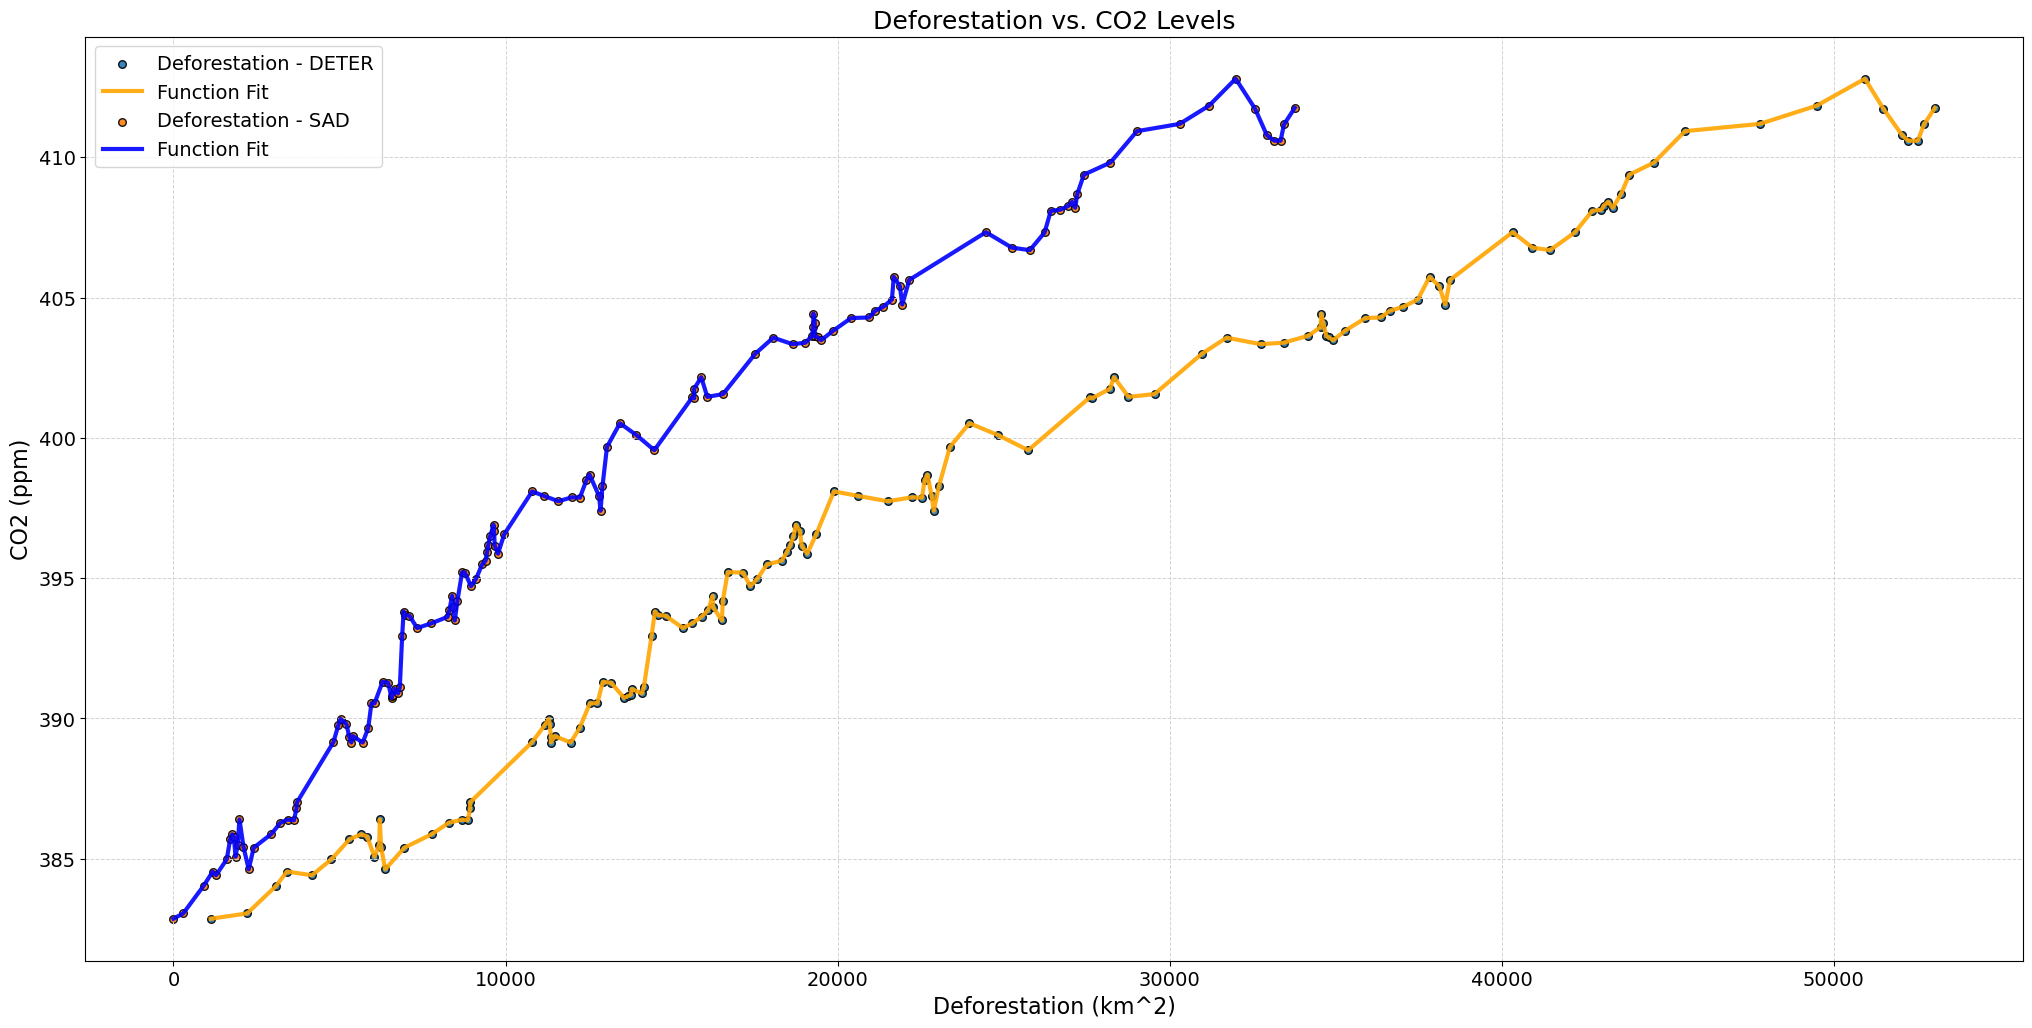

In [438]:
plt.figure(figsize=(25, 12))
plt.scatter(deforestation_vs_co2['Deforestation - DETER'], deforestation_vs_co2['CO2'], s=30, alpha=0.9,
            edgecolors='black', label="Deforestation - DETER")
plt.plot(deforestation_vs_co2['Deforestation - DETER'], deforestation_vs_co2['CO2'], color='orange', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.scatter(deforestation_vs_co2['Deforestation - SAD'], deforestation_vs_co2['CO2'], s=30, alpha=0.9,
            edgecolors='black', label="Deforestation - SAD")
plt.plot(deforestation_vs_co2['Deforestation - SAD'], deforestation_vs_co2['CO2'], color='blue', linewidth=3,
         alpha=0.9, label="Function Fit")

plt.grid(True, which='both', axis='x', linestyle='--',
         linewidth=0.7, color='lightgray')
plt.grid(True, which='major', axis='y', linestyle='--',
         linewidth=0.7, color='lightgray')

plt.title("Deforestation vs. CO2 Levels")
plt.xlabel('Deforestation (km^2)')
plt.ylabel('CO2 (ppm)')
plt.legend()
plt.show()